#### 基本思路

提取图像特征值，存入HBase,进行查重。

#### 特征值提取

图像相似性搜索领域，一般先图像特征量化，然后进行相应的匹配。

1、方向一：描述符。先抽取图像局部特征符，根据一些匹配算法进行匹对，较多适合在图像比对，人脸比对等领域；

2、方向二：描述符的特征。先抽取图像局部特征符，描述符堆砌然后降维下来，成为拥有全局信息的图像特征向量，适合形成图指纹；

3、方向三：颜色特征。使用直方图，后计算两两之间的误差，较多使其向量化，比较适合多量图像。

4、方向四：哈希化。适合大规模搜索，哈希化之后去重，或进行搜索。

5、方向五：triplet loss。深度学习，从图片相似度学习图片的表示


#### 参考
- [实例检索︱图像的实例搜索（文献、方法描述、商业案例）](https://blog.csdn.net/sinat_26917383/article/details/63306206)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from img_feature import sift, surf, orb
from helper import showimg
import matplotlib.pyplot as plt
import cv2

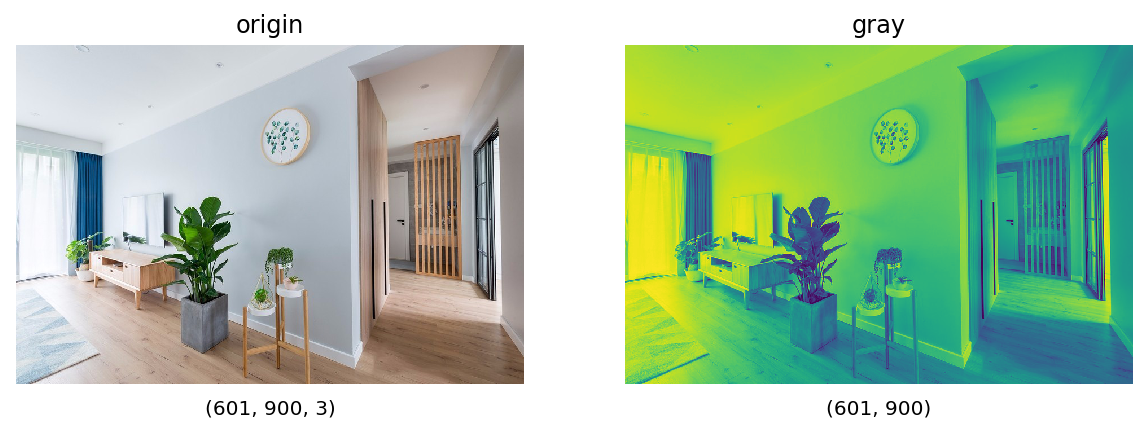

In [2]:
import cv2
img  = cv2.imread('images/origin/1.jpg')[:, :, [2, 1, 0]]
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

showimg(img, ax=axs[0], title='origin')
showimg(gray, ax=axs[1], title='gray')

In [25]:
import numpy as np
import pandas as pd
from os import listdir, path

class ImageFolder:
    def __init__(self, root='images'):
        assert isinstance(root, str)
        self.root = root
        if not path.exists(root):
            raise FileNotFoundError("路径不存在")
        if not path.isdir(root):
            raise FileNotFoundError("路径不存在")

        self.dirs = listdir(root)
        dts = dict()
        for d in self.dirs:
            img_subpath = path.join(self.root, d)
            if path.isdir(img_subpath):
                # dts[d] = [ (path.splitext(img_file)[0],path.splitext(img_file)[1]) for img_file in listdir(img_subpath)]
                for img_file in listdir(img_subpath):
                    file_name = path.splitext(img_file)[0]
                    if not file_name in dts:
                        dts[file_name] = dict()
                    dts[file_name][d] = path.join(img_subpath, img_file)
        self.imgdict = dts
    def __call__(self):
        # print(path.dirname(self.root))
        # print(path.basename(self.root))
        # head, tail = path.split(self.root)
        # root, ext = path.splitext(self.root)
        return self.imgdict

data_sets = ImageFolder()
dts = data_sets()

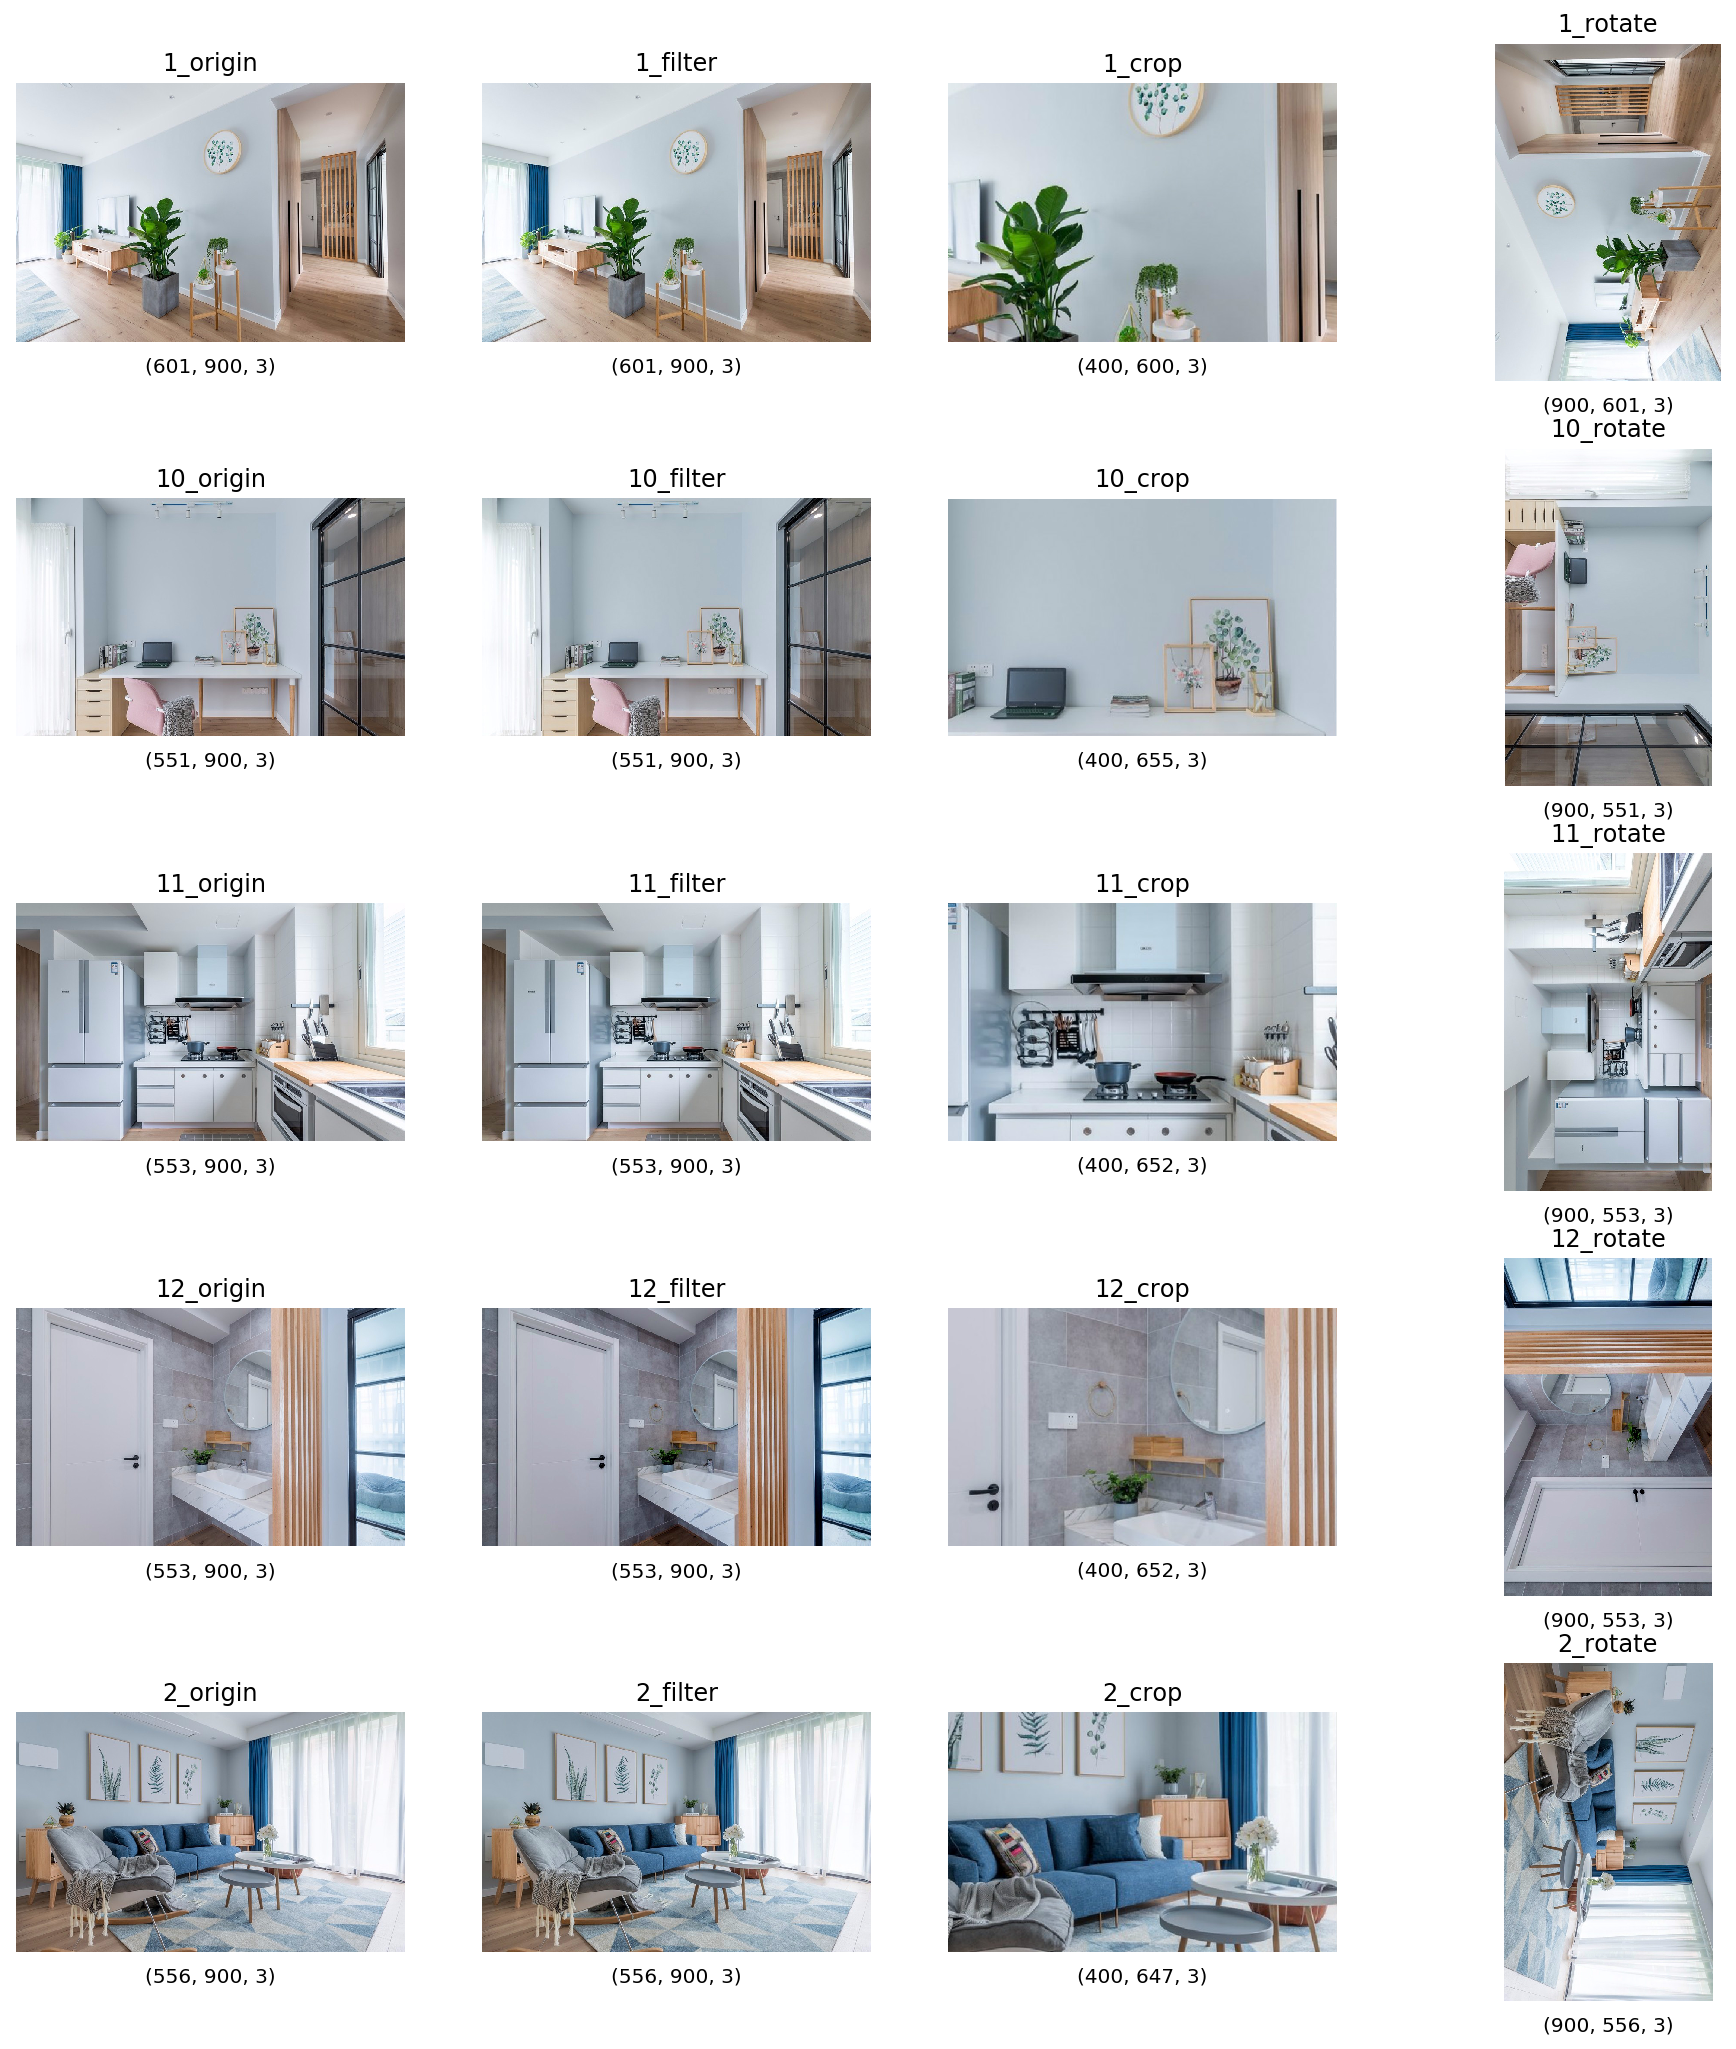

In [40]:
from time import sleep

show_num = min(5, len(dts))
fig, axs = plt.subplots(show_num, len(next(iter(dts.items()))[1]), figsize=[16, 18])

for i, (name, imgs) in enumerate(dts.items()):
    if i >= show_num:
        break
    for j, tag in enumerate(['origin', 'filter', 'crop', 'rotate']):
        img = imgs[tag]
        # print('draw {} {} {}'.format(i, j, img))
        showimg(cv2.imread(img)[:, :, [2, 1, 0]], ax=axs[i, j], title='{}_{}'.format(name, tag))
        # sleep(1)
        # pass

In [39]:
from hash import pHash

def hamming_distance(a, b=1):
        hm_dis = 0
        for i in range(len(a)):
            a_int = ord(a[i])
            b_int = ord(b[i])
            ab_nor_bin = bin(a_int ^ b_int)
            hm_dis += sum([int(ab_nor_bin[bt]) for bt in range(2, len(ab_nor_bin))])
        return hm_dis

for i, (name, imgs) in enumerate(dts.items()):
    origin_img = imgs['origin']
    out_line = 'HammingDistance for {}:\t'.format(name)
    for j, tag in enumerate(['origin', 'filter', 'crop', 'rotate']):
        img = imgs[tag]
        out_line += '\t {} = {}'.format(tag, hamming_distance(pHash(origin_img), pHash(img)))
    print(out_line)

HammingDistance for 1:		 origin = 0	 filter = 1	 crop = 84	 rotate = 139
HammingDistance for 10:		 origin = 0	 filter = 0	 crop = 54	 rotate = 118
HammingDistance for 11:		 origin = 0	 filter = 10	 crop = 192	 rotate = 194
HammingDistance for 12:		 origin = 0	 filter = 110	 crop = 247	 rotate = 239
HammingDistance for 2:		 origin = 0	 filter = 12	 crop = 274	 rotate = 269
HammingDistance for 3:		 origin = 0	 filter = 0	 crop = 138	 rotate = 270
HammingDistance for 4:		 origin = 0	 filter = 0	 crop = 126	 rotate = 275
HammingDistance for 5:		 origin = 0	 filter = 0	 crop = 196	 rotate = 73
HammingDistance for 6:		 origin = 0	 filter = 4	 crop = 145	 rotate = 142
HammingDistance for 7:		 origin = 0	 filter = 30	 crop = 56	 rotate = 224
HammingDistance for 8:		 origin = 0	 filter = 1	 crop = 130	 rotate = 266
HammingDistance for 9:		 origin = 0	 filter = 1	 crop = 125	 rotate = 121


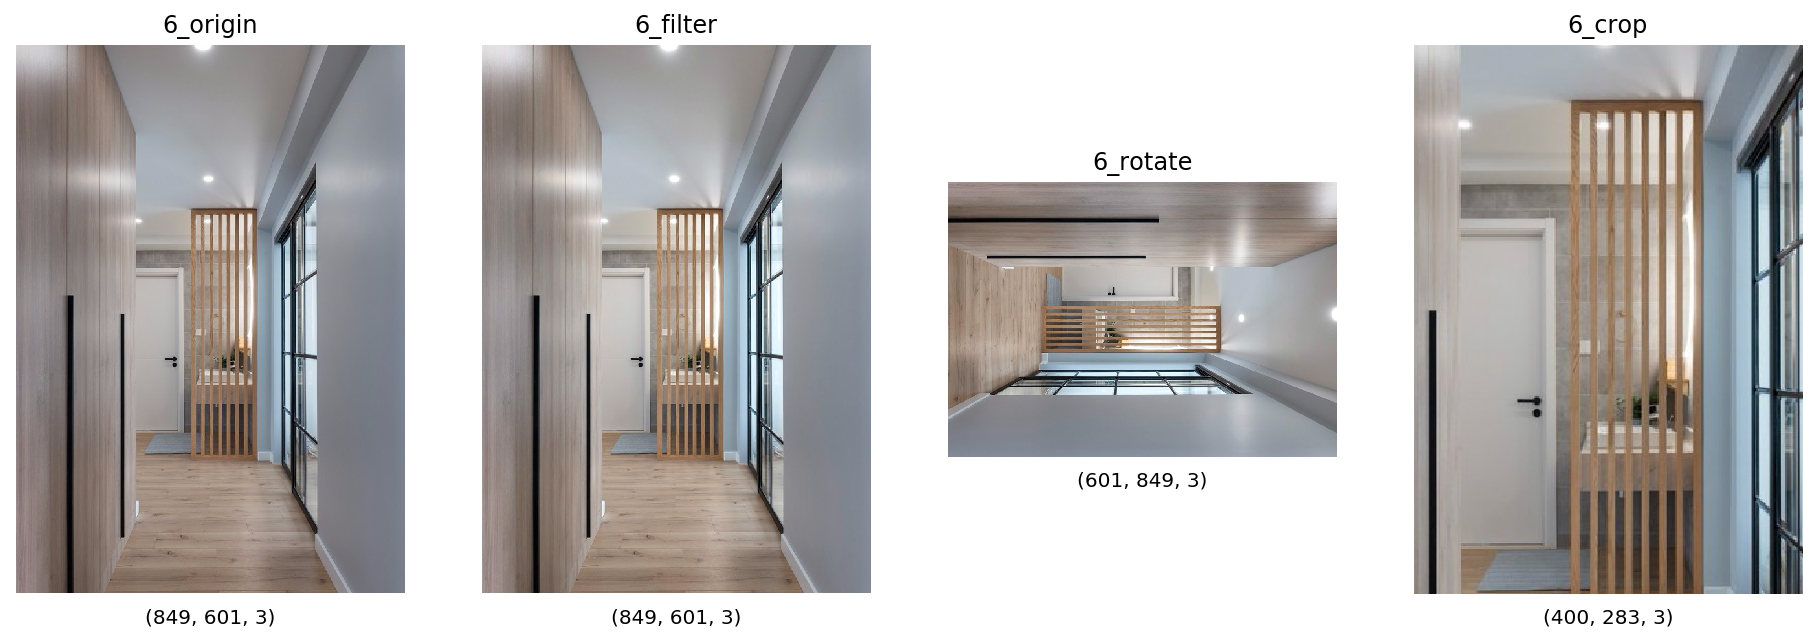

In [74]:
def showimgline(name):
    fig, axs = plt.subplots(1, 4,figsize=[16, 18])
    imgs = dts[name]
    for i, tag in enumerate(['origin', 'filter', 'rotate', 'crop']):
        showimg(cv2.imread(imgs[tag])[:, :, [2, 1, 0]], ax=axs[i], title='{}_{}'.format(name, tag))

# showimgline('6')
# showimgline('11')
showimgline('6')
# showimgline('2')
# showimgline('7')
# showimgline('12')

#### SIFT特征（尺度不变特征变换，scale-Invariant feature transform）

2004年提出的Scale Invariant Feature Transform (SIFT) 是改进的基于尺度不变的特征检测器。 
该函数会对不同的的图像尺度输出相同的结果。注意：SIFT并不检测关键点，但SIFT会通过一个特征向量来描述关键点周围区域的情况。 
SIFT并不检测DOG（difference of gaussians）

In [64]:
img_sift, sift_kp, sift_des = sift('images/demo.jpg')

fig, ax = plt.subplots(figsize=(12, 12))
showimg(img_sift, ax=ax, title='SIFT')

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\color.cpp:11147: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


#### SURF特征
SURF采用快速Hessian算法检测关键点+提取特征。 
Surf在速度上比sift要快许多，这主要得益于它的积分图技术，已经Hessian矩阵的利用减少了降采样过程，另外它得到的特征向量维数也比较少，有利于更快的进行特征点匹配。

SURF受Hessian阈值影响很大，阈值越高能识别的特征就越少，所以最优的特征可以采用最优检测的方法。 
换句话说，SURF抽取的特征点是随机的，不是固定的。 

In [ ]:
img_surf, surf_kp, surf_des = surf('images/demo.jpg')

fig, ax = plt.subplots(figsize=(12, 12))
showimg(img_surf, ax=ax, title='SURF')

#### ORB特征
一种新的具有局部不变性的特征 —— ORB特征，从它的名字中可以看出它是对FAST特征点与BREIF特征描述子的一种结合与改进，这个算法是由Ethan Rublee,Vincent Rabaud,Kurt Konolige以及Gary R.Bradski在2011年一篇名为“ORB：An Efficient Alternative to SIFT or SURF”的文章中提出。

In [ ]:
img_orb, orb_kp, orb_des = surf('images/demo.jpg')

fig, ax = plt.subplots(figsize=(12, 12))
showimg(img_orb, ax=ax, title='ORB')

#### SIFT、SURF、OBR三者比较
（1）SURF与SIFT效率对比
一般来说，SURF算法的效率是SIFT算法的3倍左右，而检测出的特征点的个数是SIFT算法的1/3左右，当然也和图像大小、纹理复杂程度、 算法参数设置有关。从第(5)组例子中可以看出，SURF算法在边缘抑制上做的似乎没有SIFT好，好多边缘都被检测成了特征点，从而导致特征点个数多于 SIFT。（本节转载于：SIFT算法与SURF算法特征检测效率对比）

（2）专利情况
ORB是除了SIFT与SURF外一个很好的选择，而且它有很高的效率，最重要的一点是它是免费的，SIFT与SURF都是有专利的，你如果在商业软件中使用，需要购买许可。

（3）三者在特征点选择的特征
SIFT输出的特征点，可以固定， 
SURF、OBR，特征点弹性的，比sift要精练一些。

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
matches = bf.match(sift_des, sift_des)
matcher = sorted(matches , key = lambda x : x.distance)

#### 哈希化


In [50]:
import numpy as np
from os import listdir

image_dir = 'images/origin'
in_files = listdir(image_dir)

arr = np.array([[1, 2], [3, 4]])
arr.flatten()

img_list = [f.split('.')[0] for f in in_files]

len(img_list)

12

In [51]:
from hash import pHash

def hamming_distance(a, b=1):
        hm_dis = 0
        for i in range(len(a)):
            a_int = ord(a[i])
            b_int = ord(b[i])
            ab_nor_bin = bin(a_int ^ b_int)
            hm_dis += sum([int(ab_nor_bin[bt]) for bt in range(2, len(ab_nor_bin))])
        return hm_dis
    
def calc_similarity(img_list):
    hmdss = list()
    for i in range(len(img_list)):
        hmdss += [[(i, j, hamming_distance(pHash('images/origin/{}.jpg'.format(img_list[i])), pHash('images/origin/{}.jpg'.format(img_list[j])))) for j in range(len(img_list)) if i != j]]
    return hmdss

def get_similarity(sim_list):
    min_dist_list = list()
    for sim in sim_list:
        min_a, min_b, min_dist = sim[0]
        for (a, b, d) in sim:
            if d < min_dist:
                min_a, min_b, min_dist = a, b, d
        min_dist_list.append((min_a, min_b, min_dist))
    return min_dist_list

min_dist_list = get_similarity(calc_similarity(img_list))

unique_list = list()

for sim in min_dist_list:
    if (not (sim[1], sim[0], sim[2]) in unique_list) and (not sim in unique_list):
        unique_list.append(sim)

unique_list

[(0, 1, 64),
 (1, 7, 29),
 (2, 1, 152),
 (3, 6, 201),
 (4, 0, 219),
 (5, 7, 43),
 (6, 5, 116),
 (8, 5, 85),
 (9, 0, 74),
 (10, 7, 116),
 (11, 0, 72)]

In [57]:
# fig, axs = plt.subplots(len(unique_list), 2,  figsize=[8, 14])

for i, item in enumerate(unique_list):
    img0_path = 'images/origin/{}.jpg'.format(img_list[item[0]])
    img1_path = 'images/origin/{}.jpg'.format(img_list[item[1]])
    img0 = cv2.imread(img0_path)[:, :, [2, 1, 0]]
    img1 = cv2.imread(img1_path)[:, :, [2, 1, 0]]
    print('HammingDistance from \t {} \t to \t{} \t= {}'.format(img_list[item[0]], img_list[item[1]], item[2]))
    # showimg(img0, ax=axs[i, 0], title='HammingDistance = {}'.format(item[2]))
    # showimg(img1, ax=axs[i, 1], title='from {} to {}'.format(img_list[item[0]], img_list[item[1]]))

HammingDistance from 	 1 	 to 	10 	= 64
HammingDistance from 	 10 	 to 	5 	= 29
HammingDistance from 	 11 	 to 	10 	= 152
HammingDistance from 	 12 	 to 	4 	= 201
HammingDistance from 	 2 	 to 	1 	= 219
HammingDistance from 	 3 	 to 	5 	= 43
HammingDistance from 	 4 	 to 	3 	= 116
HammingDistance from 	 6 	 to 	3 	= 85
HammingDistance from 	 7 	 to 	1 	= 74
HammingDistance from 	 8 	 to 	5 	= 116
HammingDistance from 	 9 	 to 	1 	= 72


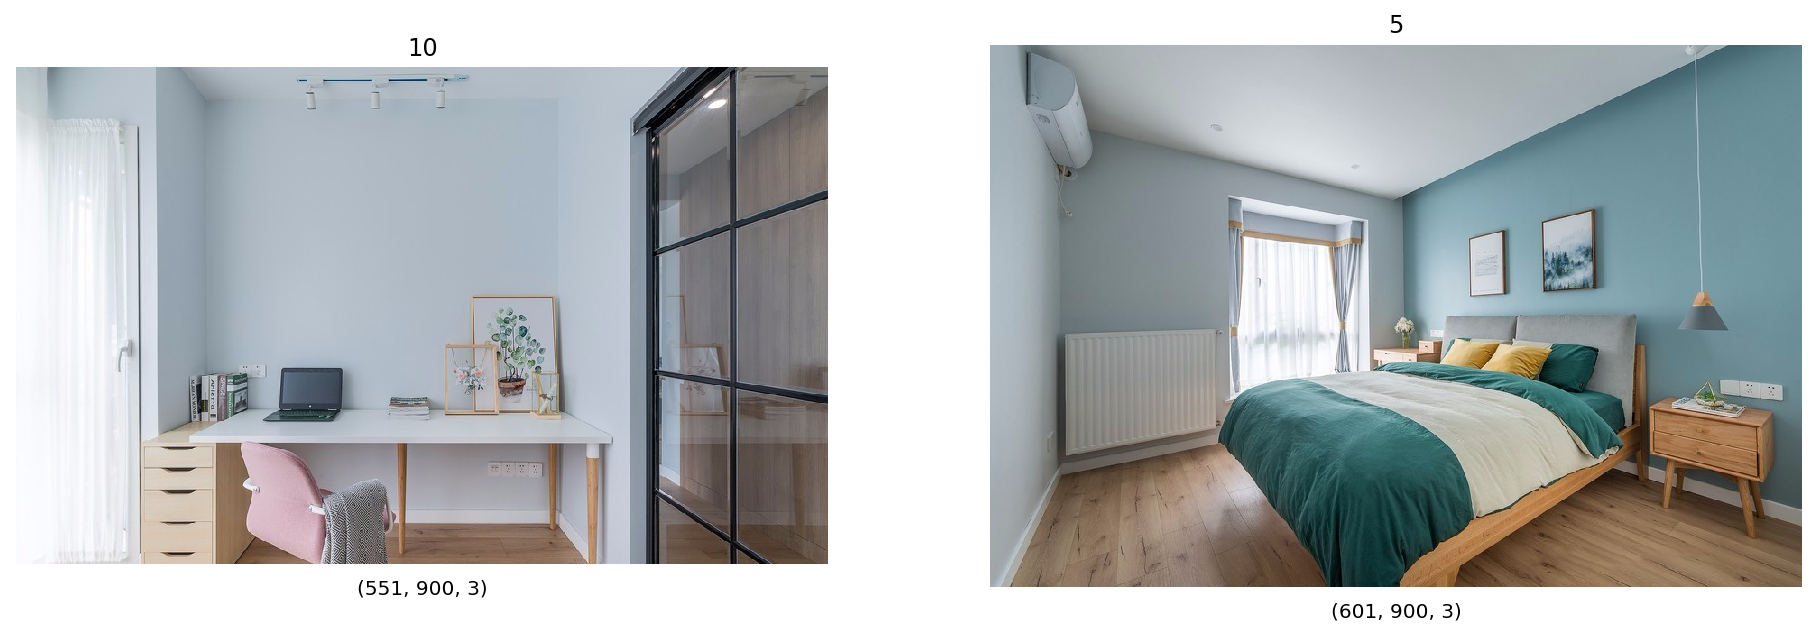

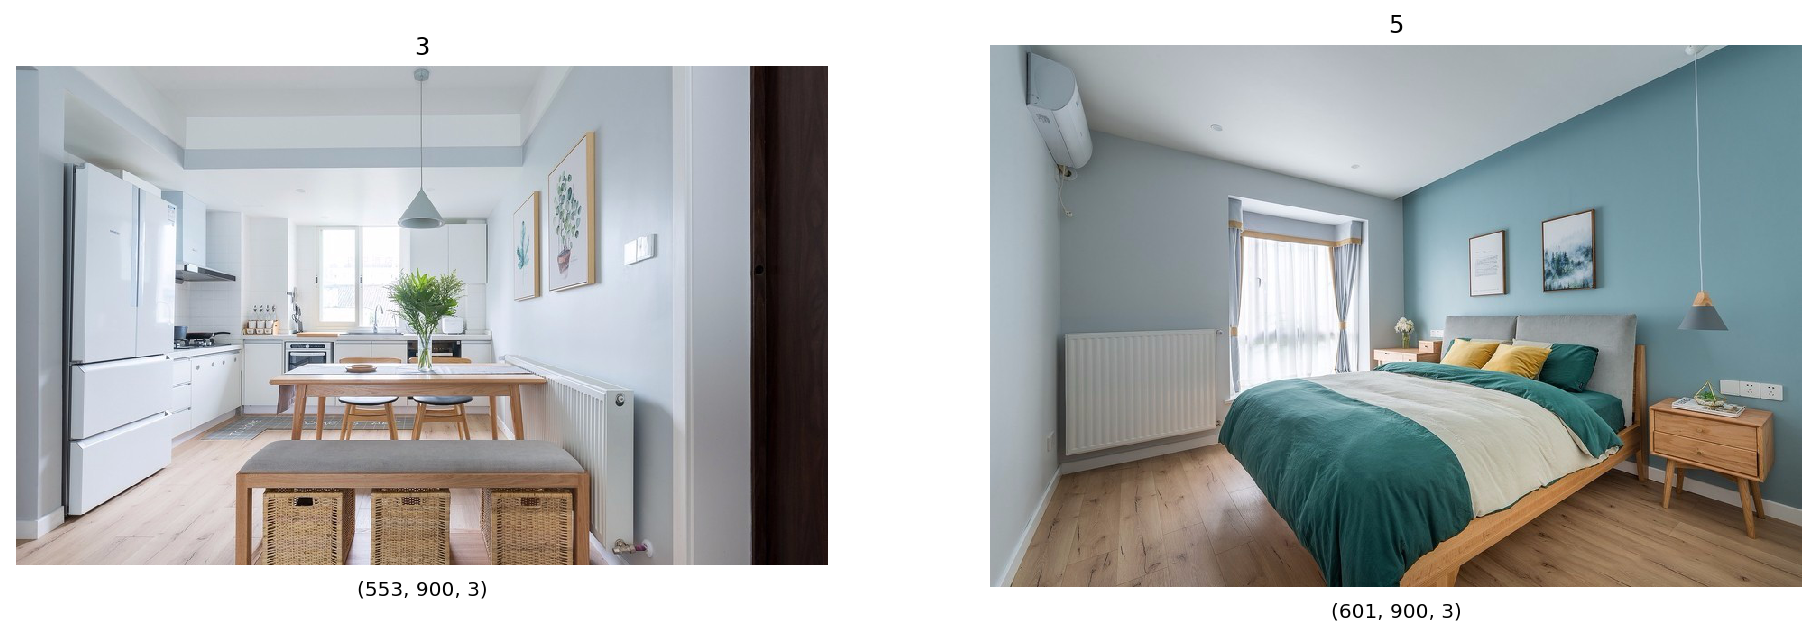

In [60]:
def showimglinename(name1, name2):
    fig, axs = plt.subplots(1, 2,figsize=[16, 18])
    showimg(cv2.imread(dts[name1]['origin'])[:, :, [2, 1, 0]], ax=axs[0], title=name1)
    showimg(cv2.imread(dts[name2]['origin'])[:, :, [2, 1, 0]], ax=axs[1], title=name2)

showimglinename('10', '5')
showimglinename('3', '5')

In [ ]:
orb_des.flatten()[0] * 1000000

In [ ]:
img_orb.shape

In [ ]:
img_orb[0: 1014, 0:1100, [1, 0]].shape

In [ ]:
img

In [67]:
dir()

['ImageFolder',
 'In',
 'Out',
 '_',
 '_15',
 '_19',
 '_20',
 '_49',
 '_50',
 '_6',
 '_65',
 '_66',
 '_7',
 '_8',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i56',
 '_i57',
 '_i58',
 '_i59',
 '_i6',
 '_i60',
 '_i61',
 '_i62',
 '_i63',
 '_i64',
 '_i65',
 '_i66',
 '_i67',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'axs',
 'cv2',
 'data_sets',
 'datasets',
 'exit',
 'ext',
 'fig',
 'get_ipython',
 'gray',
 'head',
 'img',
 'img_data